In [28]:
import numpy as np
import pandas as pd
from pandas import Categorical
from collections import OrderedDict

from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
train_test = pd.read_csv("./train_test.csv",)
weather = pd.read_csv("./weather.csv")
spray = pd.read_csv('./spray.csv')[['Date','Latitude','Longitude']]
mapdata = np.loadtxt("../mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")

###  Join train/test and weather on date and station

In [30]:
data = pd.merge(train_test,
             weather,
             left_on = ['Date','ClosestStation'],
             right_on = ['Date','Station'])
spray['Date'] = pd.to_datetime(spray['Date'])
data['Date'] = pd.to_datetime(data['Date'])

### Plot the spray areas

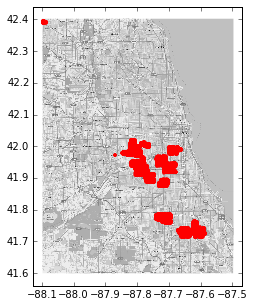

In [31]:
lats = pd.concat([data.Latitude,spray.Latitude])
lons = pd.concat([data.Longitude,spray.Longitude])
coords_extents = (np.floor(10*lons.min())/10.0,np.ceil(10*lons.max())/10.0,np.floor(10*lats.min())/10.0,np.ceil(10*lats.max())/10.0)
lonMin,lonMax,latMin,latMax = coords_extents

plt.imshow(mapdata,extent = coords_extents, cmap = plt.get_cmap('gray'))
plt.scatter(spray.Longitude,spray.Latitude,marker='.',color='red')
plt.gcf().set_size_inches(10,5)
plt.show()

These spray areas cluster rather nicely. Lets lump them into clusters.

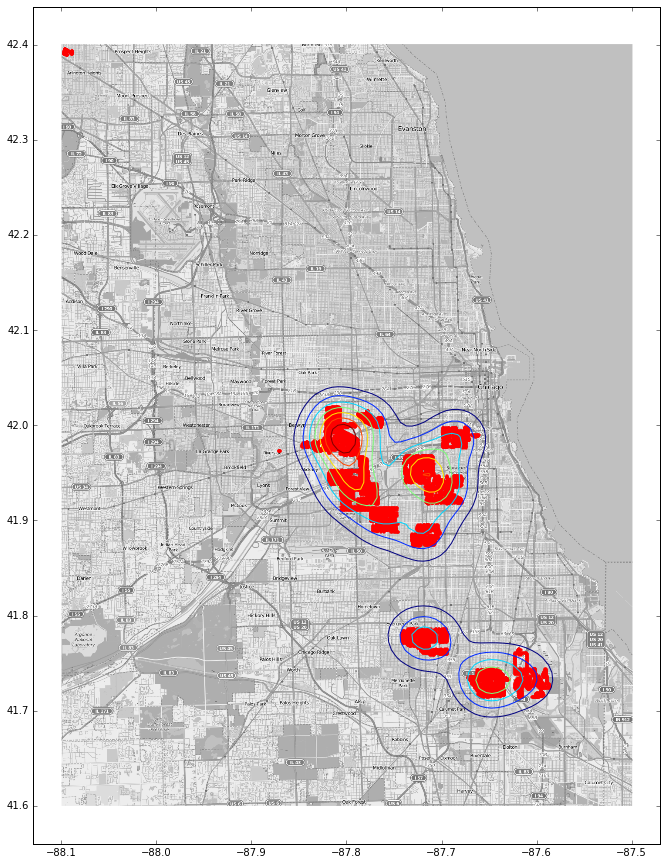

In [32]:
grain = 100

X = spray[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.02)
kd.fit(X)

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

xv,yv = np.meshgrid(np.linspace(lonMin, lonMax, grain), 
                    np.linspace(latMin, latMax, grain))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(grain,grain))

plt.imshow(mapdata,extent = coords_extents, cmap = plt.get_cmap('gray'))
plt.scatter(spray.Longitude,spray.Latitude,marker='.',color='red')
plt.contour(zv, origin='lower',extent=coords_extents)
plt.gcf().set_size_inches(30,15)
plt.show()

We can use this data to create a rather naive spray feature:
    - For every day sprays were done, produce a kernel density
      estimate, thereby modeling the densities of sprays for that day.
    - For every day of data, find the most recent spray date (if any) within the last month.
    - The spray feature is the value of the the kernel density for the most recent spray
      in the last month, and 0 if no sprays have occurred within the last month.

In [33]:
data_dates = sorted(np.unique(data['Date']))
spray_dates = sorted(np.unique(spray['Date']))
spray_densities = {}
for date in spray_dates:
    sprays = spray[spray.Date == date][['Longitude','Latitude']].values
    spray_densities[date] = KernelDensity(bandwidth=0.2).fit(sprays)

In [34]:
sprays_within_1_month = {}

def day_difference(d1,d2):
    return np.int(np.timedelta64(d2-d1,'D') / np.timedelta64(1,'D'))
    
for i in range(len(data_dates)):
    d = data_dates[i]
    recent_sprays = [date for date in spray_dates 
                          if day_difference(date,d) <= 31
                          and day_difference(date,d) > 0]
    most_recent_spray = recent_sprays[-1] if recent_sprays else None
    sprays_within_1_month[d] = most_recent_spray
    
dates = data['Date'].values
coords = data[['Longitude','Latitude']].values
spray_feature = np.zeros(data.shape[0])    
for i in range(len(spray_feature)):
    d = dates[i]
    c = coords[i]
    if sprays_within_1_month[d]:
        spray_feature[i] = np.exp(spray_densities[sprays_within_1_month[d]].score_samples(c)[0])
data['SprayIntensity'] = spray_feature

In [35]:
columns_to_remove = ['ClosestStation','Station']
data_dtypes = {
    'Dataset':'category',
    'ID':'int',
    'YearMonth': 'category',
    'Year': 'category',
    'Month': 'category',
    'Week': 'category',
    'Address': 'category',
    'Species': 'category',
    'Block': 'category',
    'Street': 'category',
    'Trap': 'category',
    'AddressNumberAndStreet': 'category',
    'Latitude': 'float32',
    'Longitude': 'float32',
    'AddressAccuracy': 'category',
    'NumMosquitos': 'int',
    'Tmax': 'float32',
    'Tmin': 'float32',
    'Tavg': 'float32',
    'Depart': 'category',
    'DewPoint': 'float32',
    'WetBulb': 'float32',
    'Heat': 'category',
    'Cool': 'category',
    'Sunrise': 'float32',
    'Sunset': 'float32',
    'CodeSum': 'category',
    'PrecipTotal': 'float32',
    'StnPressure': 'float32',
    'SeaLevel': 'float32',
    'ResultSpeed': 'float32',
    'ResultDir': 'float32',
    'AvgSpeed': 'float32',
    'SprayIntensity': 'float32',
    'WnvPresent': 'category',
}

column_order = [
    'Dataset',
    'ID',
    'Date',
    'Year',
    'Month',
    'YearMonth',
    'Week',
    'Address',
    'Species',
    'Block',
    'Street',
    'Trap',
    'AddressNumberAndStreet',
    'Latitude',
    'Longitude',
    'AddressAccuracy',
    'NumMosquitos',
    'Tmax',
    'Tmin',
    'Tavg',
    'Depart',
    'DewPoint',
    'WetBulb',
    'Heat',
    'Cool',
    'Sunrise',
    'Sunset',
    'CodeSum',
    'PrecipTotal',
    'StnPressure',
    'SeaLevel',
    'ResultSpeed',
    'ResultDir',
    'AvgSpeed',
    'SprayIntensity',
    'WnvPresent'
]

data = data.drop(columns_to_remove,axis=1)
for col,datatype in data_dtypes.items():
    data[col] = data[col].astype(datatype)

data = data[column_order]

In [36]:
data

,Dataset,ID,Date,Year,Month,YearMonth,Week,Address,Species,Block,...,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,SprayIntensity,WnvPresent
0,Train,1,2007-05-29,2007,May,2007-5,22,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
1,Train,2,2007-05-29,2007,May,2007-5,22,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
2,Train,3,2007-05-29,2007,May,2007-5,22,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
3,Train,4,2007-05-29,2007,May,2007-5,22,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
4,Train,5,2007-05-29,2007,May,2007-5,22,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
5,Train,22,2007-05-29,2007,May,2007-5,22,"6500 North Oak Park Avenue, Chicago, IL 60631,...",CULEX PIPIENS/RESTUANS,65,...,1917,BR HZ,0.00,29.389999,30.110001,5.8,18,6.5,0,0
6,Train,6,2007-05-29,2007,May,2007-5,22,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,...,1917,BR HZ,0.00,29.440001,30.090000,5.8,16,7.4,0,0
7,Train,7,2007-05-29,2007,May,2007-5,22,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,...,1917,BR HZ,0.00,29.440001,30.090000,5.8,16,7.4,0,0
8,Train,8,2007-05-29,2007,May,2007-5,22,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,...,1917,BR HZ,0.00,29.440001,30.090000,5.8,16,7.4,0,0
9,Train,9,2007-05-29,2007,May,2007-5,22,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,...,1917,BR HZ,0.00,29.440001,30.090000,5.8,16,7.4,0,0


In [38]:
data.to_csv("./joined_data.csv",index = False)
data[data.Dataset == 'Train'].to_csv('./joined_train.csv',index=False)